## Compare likelihoods for theories with different Hubble expansion / growth

We redo the notebook likelihood_test, but now varying also $H_0$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import linear_power_model

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation to use to generate synthetic data
test_sim_label='h'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [4]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/h_sim/sim_plus/paramfile.genic
H0 = 7.4000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0138E-09, n_s = 9.6756E-01, alpha_s = 0.0000E+00


### Setup archive of P1D measurements from simulations and train the emulator

In [5]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 279 points
Optimised


### Setup relevant cosmology objects

In [7]:
# Cosmology with Planck value of H_0 (to be used as fiducial)
cosmo_lowH0=camb_cosmo.get_cosmology()
camb_cosmo.print_info(cosmo_lowH0)
# compute linP parameters
linP_lowH0=linear_power_model.LinearPowerModel(cosmo=cosmo_lowH0)
old_like_params_lowH0=linP_lowH0.get_likelihood_parameters()
print('old likelihood parameters')
for par in old_like_params_lowH0:
    print(par.info_str())
# setup camb model (needed in full_theory)
camb_model_lowH0=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_lowH0)
new_like_params_lowH0=camb_model_lowH0.get_likelihood_parameters()
print('new likelihood parameters')
for par in new_like_params_lowH0:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters
g_star = 0.9677508579459803
f_star = 0.9813935108004337
Delta2_star = 0.3603423347991169
n_star = -2.299511628221443
alpha_star = -0.2162904297637917
new likelihood parameters
ombh2 = 0.022
omch2 = 0.12
As = 2.1e-09
ns = 0.965
H0 = 67.0
mnu = 0.0


In [8]:
# Cosmology with SHOES value of H_0 (to be used as test)
cosmo_highH0=camb_cosmo.get_cosmology(H0=74.0)
camb_cosmo.print_info(cosmo_highH0)
# compute linP parameters
linP_highH0=linear_power_model.LinearPowerModel(cosmo=cosmo_highH0)
old_like_params_highH0=linP_highH0.get_likelihood_parameters()
print('old likelihood parameters')
for par in old_like_params_highH0:
    print(par.info_str())
# setup camb model (needed in full_theory)
camb_model_highH0=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_highH0)
new_like_params_highH0=camb_model_highH0.get_likelihood_parameters()
print('new likelihood parameters')
for par in new_like_params_highH0:
    print(par.info_str())

H0 = 7.4000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters
g_star = 0.9577005905767146
f_star = 0.9758143773211623
Delta2_star = 0.36028068834306826
n_star = -2.300640533651198
alpha_star = -0.21629143900384265
new likelihood parameters
ombh2 = 0.022
omch2 = 0.12
As = 2.1e-09
ns = 0.965
H0 = 74.0
mnu = 0.0


### Setup and compare theory objects for low $H_0$ cosmology

Start by setting up an old theory object, that uses only compressed linP parameters

In [9]:
old_theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_lowH0,verbose=verbose)
old_emu_calls_lowH0=old_theory.get_emulator_calls()

Setup now a new theory object, that holds a CAMB object

In [10]:
new_theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_lowH0,verbose=verbose)
new_emu_calls_lowH0=new_theory.get_emulator_calls(return_M_of_z=False)

In [11]:
print("z=2 emulator calls for old theory = ", old_emu_calls_lowH0[0])
print("z=2 emulator calls for new theory = ", new_emu_calls_lowH0[0])

z=2 emulator calls for old theory =  {'Delta2_p': 0.6364390920214466, 'n_p': -2.3026192520793582, 'alpha_p': -0.21536149675798316, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls for new theory =  {'Delta2_p': 0.6364390920214466, 'n_p': -2.302619252079357, 'alpha_p': -0.21536149675800592, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


Note that the numbers above are not supposed to exactly match, since kp_Mpc is slightly different in both theories

### Compare now emulator calls for the high $H_0$ cosmology

In [12]:
# call the old theory, but using the freshly computed likelihood parameters from the test cosmology
old_emu_calls_highH0=old_theory.get_emulator_calls(like_params=old_like_params_highH0)

In [13]:
# we want to study also cases where we ignore some of the parameters
cull_params=['f_star','g_star','alpha_star']
culled_like_params_highH0 = [par for par in old_like_params_highH0 if par.name not in cull_params]
for par in culled_like_params_highH0:
    print(par.info_str())
# same, but using only the culled parameters
culled_emu_calls_highH0=old_theory.get_emulator_calls(like_params=culled_like_params_highH0)

Delta2_star = 0.36028068834306826
n_star = -2.300640533651198


In [14]:
# call the new theory, but using the freshly computed likelihood parameters for the test cosmology
new_emu_calls_highH0=new_theory.get_emulator_calls(like_params=new_like_params_highH0,return_M_of_z=False)

In [15]:
print("z = {} emulator calls from old theory = {}".format(data.z[0],old_emu_calls_highH0[0]))
print("z = {} emulator calls from culled theory = {}".format(data.z[0],culled_emu_calls_highH0[0]))
print("z = {} emulator calls from new theory = {}".format(data.z[0],new_emu_calls_highH0[0]))

z = 2.0 emulator calls from old theory = {'Delta2_p': 0.634280585046646, 'n_p': -2.3037481719705344, 'alpha_p': -0.21536250599803747, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.1302201296377235, 'kF_Mpc': 9.274779172461406}
z = 2.0 emulator calls from culled theory = {'Delta2_p': 0.6363199183651905, 'n_p': -2.3037481575091143, 'alpha_p': -0.21536149675798608, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from new theory = {'Delta2_p': 0.6309071989358371, 'n_p': -2.3026193685325484, 'alpha_p': -0.21536163215566162, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.12925597769550834, 'kF_Mpc': 9.34396201809978}


In [16]:
print("z = {} emulator calls from old theory = {}".format(data.z[-1],old_emu_calls_highH0[-1]))
print("z = {} emulator calls from culled theory = {}".format(data.z[-1],culled_emu_calls_highH0[-1]))
print("z = {} emulator calls from new theory = {}".format(data.z[-1],new_emu_calls_highH0[-1]))

z = 4.0 emulator calls from old theory = {'Delta2_p': 0.23493263091540853, 'n_p': -2.303748191354048, 'alpha_p': -0.21536211620293513, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.11286592125950634, 'kF_Mpc': 12.7980770382843}
z = 4.0 emulator calls from culled theory = {'Delta2_p': 0.2343484009201081, 'n_p': -2.303748176892625, 'alpha_p': -0.2153611069628919, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from new theory = {'Delta2_p': 0.23392763021122306, 'n_p': -2.302619316673417, 'alpha_p': -0.21536227623982934, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1121811457105948, 'kF_Mpc': 12.876198991607117}


Both new and old theories make the same emulator call for a theory that is not the fiducial!

## Test now the likelihood objects

### Old likelihood using all five parameters

In [17]:
## Set up a likelihood object with the old theory object
#old_free_params=['Delta2_star','n_star']
old_free_params=['Delta2_star','n_star','alpha_star','f_star','g_star']
old_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_param_names=old_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [18]:
# get parameter values in cube for test cosmology
old_values_highH0=old_like.sampling_point_from_parameters(old_like_params_highH0)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_highH0):
    print(par.info_str(),',',par.value_in_cube())
old_like.get_log_like(values=old_values_highH0,ignore_log_det_cov=False)

Delta2_star = 0.36028068834306826 , 0.7352045889537883
n_star = -2.300640533651198 , 0.4935946634880213
alpha_star = -0.21629143900384265 , 0.48825964541961236
f_star = 0.9758143773211623 , 0.6453594330290574
g_star = 0.9577005905767146 , 0.1925147644178669


-39.48077537118112

### Old likelihood using only two parameters

In [19]:
## Set up a likelihood object with the old theory object, but now with only 2 key parameters
culled_free_params=['Delta2_star','n_star']
culled_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_param_names=culled_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [20]:
# get parameter values in cube for test cosmology
culled_values_highH0=culled_like.sampling_point_from_parameters(culled_like_params_highH0)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_highH0):
    print(par.info_str(),',',par.value_in_cube())
culled_like.get_log_like(values=culled_values_highH0,ignore_log_det_cov=False)

Delta2_star = 0.36028068834306826 , 0.7352045889537883
n_star = -2.300640533651198 , 0.4935946634880213


-39.44987220902168

### New likelihood

In [21]:
## Set up a likelihood object with the new theory object
new_free_params=["As","ns","H0"]
new_like=likelihood.Likelihood(data=data,theory=new_theory,
                            free_param_names=new_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [22]:
# get parameter values in cube for test cosmology in new theory
new_values_highH0=new_like.sampling_point_from_parameters(new_like_params_highH0)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_highH0):
    print(par.info_str(),',',par.value_in_cube())

As = 2.1e-09 , 0.5500000000000002
ns = 0.965 , 0.4333333333333329
H0 = 74.0 , 0.7857142857142857


In [23]:
new_like.get_log_like(values=new_values_highH0,ignore_log_det_cov=False)

-42.68054108355136

These results are not great... The chi2 are quite different, but the emulator calls seemed fine... Let me inspect.

### P1D predictions from the different theories

In [24]:
zs=data.z
k_kms=np.logspace(np.log10(min(data.k)),np.log10(max(data.k)),500)
old_p1d=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_highH0,return_covar=False)

In [25]:
culled_p1d=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_highH0,return_covar=False)

In [26]:
new_p1d=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_highH0,return_covar=False)

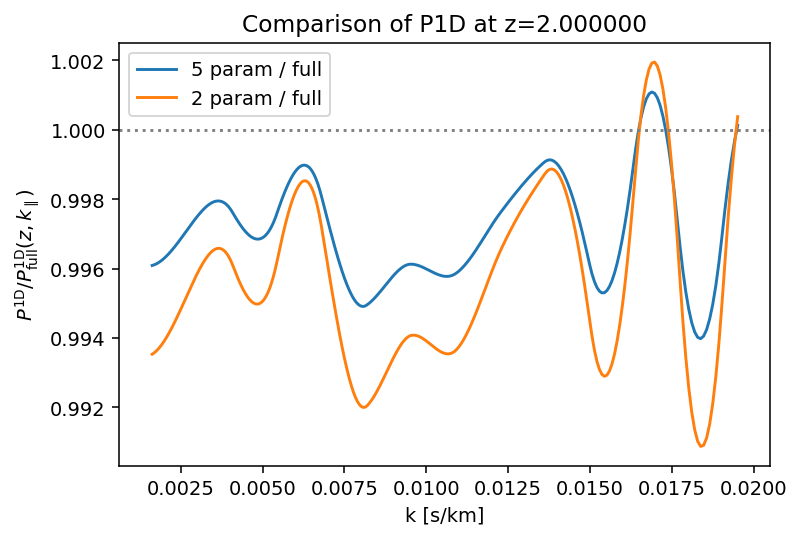

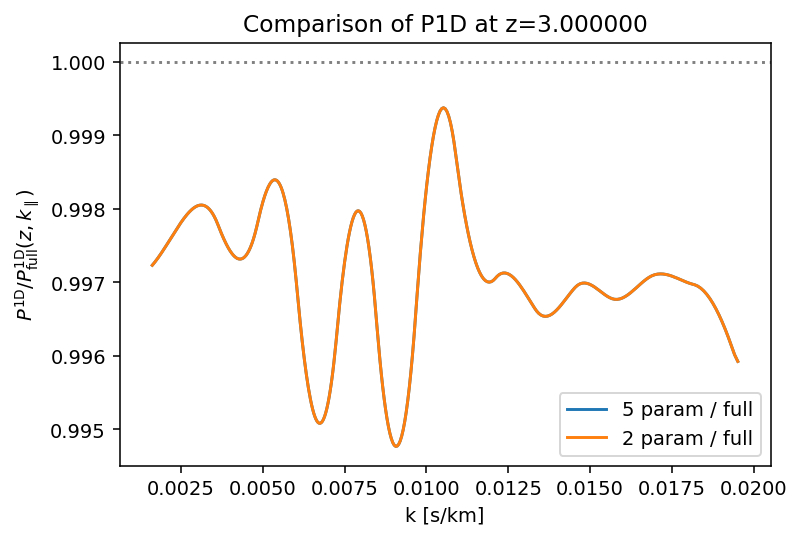

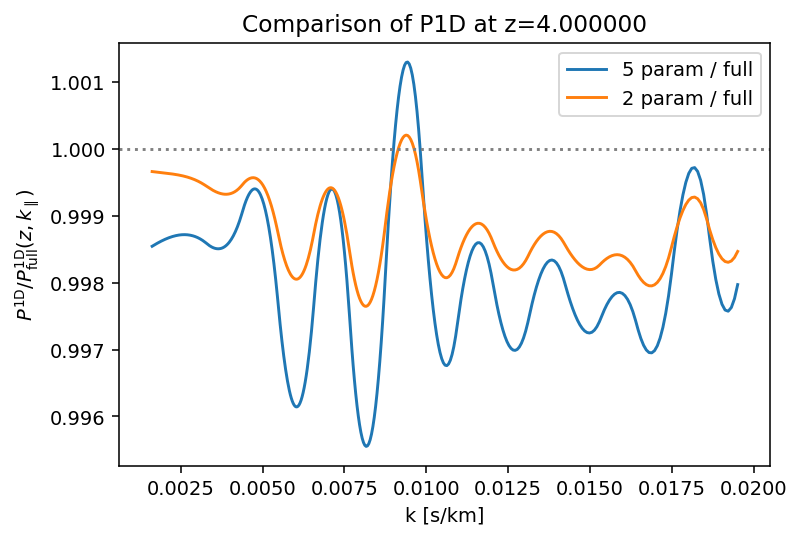

In [27]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d[iz]/new_p1d[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d[iz]/new_p1d[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    #plt.tight_layout()
    plt.title('Comparison of P1D at z=%f'%z)

I think these plots look pretty good!